In [26]:
import os
import time
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from catboost import Pool
from sklearn.metrics import (
    root_mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
    median_absolute_error,
    r2_score,
    explained_variance_score)

# Models
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from scikeras.wrappers import KerasRegressor

In [27]:
df = pd.read_csv("../Dataset/PVT_1225.csv")
df = df.sample(frac=1, random_state=42).reset_index(drop=True)  # 🔀 Shuffle rows

# Preview columns
print(df.columns.tolist())

# Define features and target
X = df.drop(columns=["Pb", "Bob"])
y = df["Pb"]

['Tf', 'Rs', 'gg', 'api', 'Pb', 'Bob']


In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")

Training samples: 857
Testing samples: 368


# XGBoost

In [30]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from tqdm import tqdm
import time
import numpy as np

# Tuning XGBoost
param_grid = [
    {"n_estimators": n, "learning_rate": lr, "max_depth": d}
    for n in [100, 200]
    for lr in [0.01, 0.05, 0.1]
    for d in [4, 6, 8]
]

best_xgb_params, best_xgb_score = None, -float("inf")
best_xgb_mse = best_xgb_rmse = best_xgb_mae = best_xgb_r2 = best_xgb_adj_r2 = best_xgb_time = None

with tqdm(total=len(param_grid), desc="Tuning XGBoost") as pbar:
    for params in param_grid:
        start_time = time.time()
        xgb_model = XGBRegressor(**params, random_state=42)
        xgb_model.fit(X_train, y_train)
        y_pred_xgb = xgb_model.predict(X_test)
        end_time = time.time()

        # Metrics
        mse = mean_squared_error(y_test, y_pred_xgb)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred_xgb)
        r2 = r2_score(y_test, y_pred_xgb)
        elapsed = end_time - start_time

        # Adjusted R²
        n, p = len(y_test), X_test.shape[1]
        adj_r2 = 1 - ((1 - r2) * (n - 1) / (n - p - 1)) if n > p + 1 else None

        # Weighted Score (penalize RMSE, reward R²)
        score = -rmse + (r2 * 100)

        if score > best_xgb_score:
            best_xgb_params = params
            best_xgb_score = score
            best_xgb_mse = mse
            best_xgb_rmse = rmse
            best_xgb_mae = mae
            best_xgb_r2 = r2
            best_xgb_adj_r2 = adj_r2
            best_xgb_time = elapsed

        pbar.update(1)

# Print
print(f"\nBest XGBoost Params: {best_xgb_params}, Best Score: {best_xgb_score:.4f}, "
      f"Best MSE: {best_xgb_mse:.4f}, Best RMSE: {best_xgb_rmse:.4f}, Best MAE: {best_xgb_mae:.4f}, "
      f"Best R²: {best_xgb_r2:.4f}, "
      f"{f'Best Adjusted R²: {best_xgb_adj_r2:.4f}' if best_xgb_adj_r2 is not None else 'Best Adjusted R²: N/A'}, "
      f"XGBoost Training Time: {best_xgb_time:.4f}s")


Tuning XGBoost: 100%|███████████████████████████| 18/18 [00:04<00:00,  3.80it/s]


Best XGBoost Params: {'n_estimators': 200, 'learning_rate': 0.1, 'max_depth': 4}, Best Score: -236.4660, Best MSE: 108293.4906, Best RMSE: 329.0798, Best MAE: 178.8929, Best R²: 0.9261, Best Adjusted R²: 0.9253, XGBoost Training Time: 0.2221s


# CatBoost

In [32]:
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from tqdm import tqdm
import time
import numpy as np

# Tuning CatBoost
param_grid = [
    {"iterations": i, "learning_rate": lr, "depth": d, "l2_leaf_reg": reg}
    for i in [500, 1000]
    for lr in [0.01, 0.05, 0.1]
    for d in [4, 6]
    for reg in [3, 5, 7]
]

best_cat_params, best_cat_score = None, -float("inf")
best_cat_mse = best_cat_rmse = best_cat_mae = best_cat_r2 = best_cat_adj_r2 = best_cat_time = None

with tqdm(total=len(param_grid), desc="Tuning CatBoost") as pbar:
    for params in param_grid:
        start_time = time.time()
        cat_model = CatBoostRegressor(logging_level='Silent', random_state=42, **params)
        cat_model.fit(X_train, y_train)
        y_pred_cat = cat_model.predict(X_test)
        end_time = time.time()

        # Metrics
        mse = mean_squared_error(y_test, y_pred_cat)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred_cat)
        r2 = r2_score(y_test, y_pred_cat)
        elapsed = end_time - start_time

        # Adjusted R²
        n, p = len(y_test), X_test.shape[1]
        adj_r2 = 1 - ((1 - r2) * (n - 1) / (n - p - 1)) if n > p + 1 else None

        # Weighted Score (penalize RMSE, reward R²)
        score = -rmse + (r2 * 100)

        if score > best_cat_score:
            best_cat_params = params
            best_cat_score = score
            best_cat_mse = mse
            best_cat_rmse = rmse
            best_cat_mae = mae
            best_cat_r2 = r2
            best_cat_adj_r2 = adj_r2
            best_cat_time = elapsed

        pbar.update(1)

# Print
print(f"\nBest CatBoost Params: {best_cat_params}, Best Score: {best_cat_score:.4f}, "
      f"Best MSE: {best_cat_mse:.4f}, Best RMSE: {best_cat_rmse:.4f}, Best MAE: {best_cat_mae:.4f}, "
      f"Best R²: {best_cat_r2:.4f}, "
      f"{f'Best Adjusted R²: {best_cat_adj_r2:.4f}' if best_cat_adj_r2 is not None else 'Best Adjusted R²: N/A'}, "
      f"CatBoost Training Time: {best_cat_time:.4f}s")


Tuning CatBoost: 100%|██████████████████████████| 36/36 [00:11<00:00,  3.26it/s]


Best CatBoost Params: {'iterations': 1000, 'learning_rate': 0.05, 'depth': 4, 'l2_leaf_reg': 7}, Best Score: -213.2137, Best MSE: 94122.5616, Best RMSE: 306.7940, Best MAE: 177.0382, Best R²: 0.9358, Best Adjusted R²: 0.9351, CatBoost Training Time: 0.2981s


# Neural Network

In [41]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tqdm import tqdm
import time
import numpy as np

# Define grid
param_grid = [
    {"layers": [64, 32], "epochs": 100, "batch_size": 16},
    {"layers": [128, 64], "epochs": 100, "batch_size": 16},
    {"layers": [128, 64, 32], "epochs": 150, "batch_size": 32},
]

# Best tracking variables
best_nn_params, best_nn_score = None, -float("inf")
best_nn_mse = best_nn_rmse = best_nn_mae = best_nn_r2 = best_nn_adj_r2 = best_nn_time = None

# Tuning loop
with tqdm(total=len(param_grid), desc="Tuning Neural Network") as pbar:
    for params in param_grid:

        def create_nn():
            model = Sequential()
            model.add(Input(shape=(X_train.shape[1],)))
            for units in params["layers"]:
                model.add(Dense(units, activation='relu'))
            model.add(Dense(1))
            model.compile(optimizer=Adam(), loss='mse')
            return model

        start_time = time.time()
        nn_model = KerasRegressor(model=create_nn, epochs=params["epochs"], batch_size=params["batch_size"], verbose=0)
        nn_model.fit(X_train, y_train)
        y_pred_nn = nn_model.predict(X_test)
        end_time = time.time()

        nn_mse = mean_squared_error(y_test, y_pred_nn)
        nn_rmse = np.sqrt(nn_mse)
        nn_mae = mean_absolute_error(y_test, y_pred_nn)
        nn_r2 = r2_score(y_test, y_pred_nn)
        n = len(y_test)
        p = X_test.shape[1]
        nn_adj_r2 = 1 - ((1 - nn_r2) * (n - 1) / (n - p - 1)) if n > p + 1 else None
        nn_time = end_time - start_time

        nn_score = -nn_rmse + (nn_r2 * 100)

        if nn_score > best_nn_score:
            best_nn_params = params
            best_nn_score = nn_score
            best_nn_mse = nn_mse
            best_nn_rmse = nn_rmse
            best_nn_mae = nn_mae
            best_nn_r2 = nn_r2
            best_nn_adj_r2 = nn_adj_r2
            best_nn_time = nn_time

        pbar.update(1)

def create_best_nn():
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1],)))
    for units in best_nn_params["layers"]:
        model.add(Dense(units, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer=Adam(), loss='mse')
    return model

best_nn_model = KerasRegressor(
    model=create_best_nn,
    epochs=best_nn_params["epochs"],
    batch_size=best_nn_params["batch_size"],
    verbose=0
)
best_nn_model.fit(X_train, y_train)

# Print results
print(f"\nBest Neural Network Params: {best_nn_params}, Best Score: {best_nn_score:.4f}, Best MSE: {best_nn_mse:.4f}, "
      f"Best RMSE: {best_nn_rmse:.4f}, Best MAE: {best_nn_mae:.4f}, Best R²: {best_nn_r2:.4f}, "
      f"{f'Best Adjusted R²: {best_nn_adj_r2:.4f}' if best_nn_adj_r2 is not None else 'Best Adjusted R²: N/A'}, "
      f"Neural Net Training Time: {best_nn_time:.4f}s")


Tuning Neural Network: 100%|██████████████████████| 3/3 [00:10<00:00,  3.58s/it]



Best Neural Network Params: {'layers': [128, 64], 'epochs': 100, 'batch_size': 16}, Best Score: -429.4177, Best MSE: 261701.8622, Best RMSE: 511.5680, Best MAE: 350.6393, Best R²: 0.8215, Best Adjusted R²: 0.8195, Neural Net Training Time: 3.3490s


# Stacking Ensemble

In [43]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.svm import SVR
import time
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
from tqdm import tqdm

# Define base learners with default/approximate params
base_estimators = [
    ('lr', LinearRegression()),
    ('ridge', Ridge()),
    ('lasso', Lasso()),
    ('dt', DecisionTreeRegressor(max_depth=10)),
    ('knn', KNeighborsRegressor(n_neighbors=5)),
    ('svr', SVR()),
    ('xgb', XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=4, random_state=42))
]

# Define final estimator
final_estimator = CatBoostRegressor(verbose=0, random_state=42)

# Create the stacking model
stack = StackingRegressor(
    estimators=base_estimators,
    final_estimator=final_estimator,
    passthrough=True
)

# Fit and evaluate
start_time = time.time()
with tqdm(total=1, desc="Training Stacked Model") as pbar:
    stack.fit(X_train, y_train)
    pbar.update(1)
stack_preds = stack.predict(X_test)
end_time = time.time()

# Calculate metrics
stack_mse = mean_squared_error(y_test, stack_preds)
stack_rmse = np.sqrt(stack_mse)
stack_mae = mean_absolute_error(y_test, stack_preds)
stack_r2 = r2_score(y_test, stack_preds)
n, p = len(y_test), X_test.shape[1]
stack_adj_r2 = 1 - ((1 - stack_r2) * (n - 1) / (n - p - 1))
stack_score = -stack_rmse + (stack_r2 * 100)
stack_time = end_time - start_time

# Print results
print(f"\nBest Stacked Ensemble Score: {stack_score:.4f}, Best MSE: {stack_mse:.4f}, "
      f"Best RMSE: {stack_rmse:.4f}, Best MAE: {stack_mae:.4f}, Best R²: {stack_r2:.4f}, "
      f"Best Adjusted R²: {stack_adj_r2:.4f}, Stacked Training Time: {stack_time:.4f}s")


Training Stacked Model: 100%|█████████████████████| 1/1 [00:00<00:00,  1.01it/s]


Best Stacked Ensemble Score: -223.9727, Best MSE: 100561.1900, Best RMSE: 317.1138, Best MAE: 179.1671, Best R²: 0.9314, Best Adjusted R²: 0.9307, Stacked Training Time: 1.0040s


# ExtraTreesRegressor

In [45]:
from sklearn.ensemble import ExtraTreesRegressor

# Start timing
start_time = time.time()

# Train ExtraTrees model with tqdm progress bar
with tqdm(total=1, desc="Training ExtraTrees") as pbar:
    et_model = ExtraTreesRegressor(n_estimators=200, random_state=42)
    et_model.fit(X_train, y_train)
    pbar.update(1)

# Predict
et_preds = et_model.predict(X_test)

# End timing
et_time = time.time() - start_time

# Evaluation Metrics
et_mse = mean_squared_error(y_test, et_preds)
et_rmse = np.sqrt(et_mse)
et_mae = mean_absolute_error(y_test, et_preds)
et_r2 = r2_score(y_test, et_preds)
et_adj_r2 = 1 - ((1 - et_r2) * (len(y_test) - 1) / (len(y_test) - X_test.shape[1] - 1))

# Print results
print(f"Best ExtraTrees MSE: {et_mse:.4f}, RMSE: {et_rmse:.4f}, MAE: {et_mae:.4f}, "
      f"R²: {et_r2:.4f}, Adjusted R²: {et_adj_r2:.4f}, Training Time: {et_time:.4f}s")


Training ExtraTrees: 100%|████████████████████████| 1/1 [00:00<00:00,  6.64it/s]

Best ExtraTrees MSE: 108699.0954, RMSE: 329.6955, MAE: 177.4970, R²: 0.9259, Adjusted R²: 0.9250, Training Time: 0.1630s


# Deep Neural Network 

In [48]:
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tqdm import tqdm
import time
import numpy as np

# Define model builder
def create_deep_nn():
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1],)))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

# Grid for tuning
epoch_options = [100, 150]
batch_options = [16, 32]

best_dnn_score = -float("inf")
best_dnn_params = best_dnn_mse = best_dnn_rmse = best_dnn_mae = best_dnn_r2 = best_dnn_adj_r2 = best_dnn_time = None
best_dnn_model = None

param_grid = [(e, b) for e in epoch_options for b in batch_options]

with tqdm(total=len(param_grid), desc="Tuning Deep NN") as pbar:
    for epochs, batch_size in param_grid:
        start_time = time.time()
        dnn_model = KerasRegressor(model=create_deep_nn, epochs=epochs, batch_size=batch_size, verbose=0)
        dnn_model.fit(X_train, y_train)
        dnn_preds = dnn_model.predict(X_test)
        end_time = time.time()

        # Metrics
        dnn_mse = mean_squared_error(y_test, dnn_preds)
        dnn_rmse = np.sqrt(dnn_mse)
        dnn_mae = mean_absolute_error(y_test, dnn_preds)
        dnn_r2 = r2_score(y_test, dnn_preds)
        n, p = len(y_test), X_test.shape[1]
        dnn_adj_r2 = 1 - ((1 - dnn_r2) * (n - 1) / (n - p - 1))
        dnn_score = -dnn_rmse + (dnn_r2 * 100)
        dnn_time = end_time - start_time

        # Save best
        if dnn_score > best_dnn_score:
            best_dnn_score = dnn_score
            best_dnn_params = (epochs, batch_size)
            best_dnn_mse = dnn_mse
            best_dnn_rmse = dnn_rmse
            best_dnn_mae = dnn_mae
            best_dnn_r2 = dnn_r2
            best_dnn_adj_r2 = dnn_adj_r2
            best_dnn_time = dnn_time

            # Save the best model instance
            best_dnn_model = KerasRegressor(
                model=create_deep_nn,
                epochs=epochs,
                batch_size=batch_size,
                verbose=0
            )
            best_dnn_model.fit(X_train, y_train)

        pbar.update(1)

# Print final results
print(f"\nBest Deep NN Params: epochs={best_dnn_params[0]}, batch_size={best_dnn_params[1]}, "
      f"Best Score: {best_dnn_score:.4f}, Best MSE: {best_dnn_mse:.4f}, Best RMSE: {best_dnn_rmse:.4f}, "
      f"Best MAE: {best_dnn_mae:.4f}, Best R²: {best_dnn_r2:.4f}, Best Adjusted R²: {best_dnn_adj_r2:.4f}, "
      f"Deep NN Training Time: {best_dnn_time:.4f}s")


Tuning Deep NN: 100%|█████████████████████████████| 4/4 [00:27<00:00,  6.77s/it]


Best Deep NN Params: epochs=150, batch_size=16, Best Score: -409.0704, Best MSE: 242580.7360, Best RMSE: 492.5249, Best MAE: 351.8784, Best R²: 0.8345, Best Adjusted R²: 0.8327, Deep NN Training Time: 5.0575s


# MSE, RMSE, MAE Comparisons

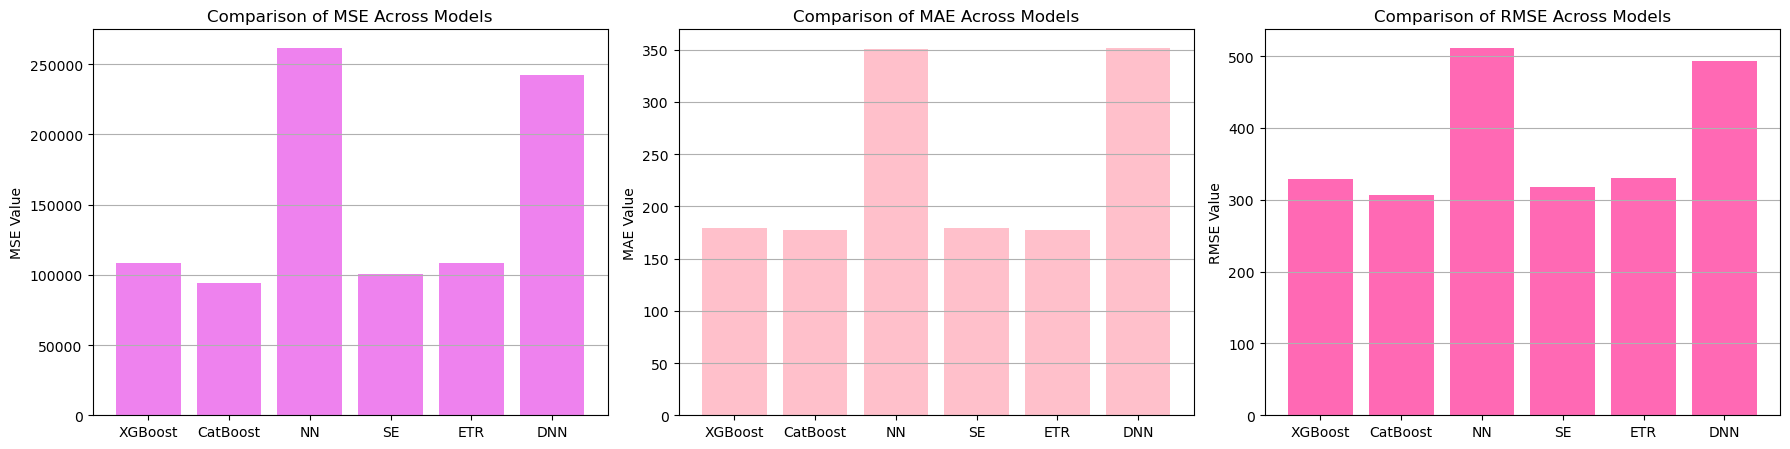

In [51]:
import matplotlib.pyplot as plt

x_labels = ["XGBoost", "CatBoost", "NN", "SE", "ETR", "DNN"]
mse_values = [best_xgb_mse, best_cat_mse, best_nn_mse, stack_mse, et_mse, best_dnn_mse]
mae_values = [best_xgb_mae, best_cat_mae, best_nn_mae, stack_mae, et_mae, best_dnn_mae]
rmse_values = [best_xgb_rmse, best_cat_rmse, best_nn_rmse, stack_rmse, et_rmse, best_dnn_rmse]

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

axs[0].bar(x_labels, mse_values, color='violet')
axs[0].set_title("Comparison of MSE Across Models")
axs[0].set_ylabel("MSE Value")
axs[0].grid(axis='y')

axs[1].bar(x_labels, mae_values, color='pink')
axs[1].set_title("Comparison of MAE Across Models")
axs[1].set_ylabel("MAE Value")
axs[1].grid(axis='y')

axs[2].bar(x_labels, rmse_values, color='hotpink')
axs[2].set_title("Comparison of RMSE Across Models")
axs[2].set_ylabel("RMSE Value")
axs[2].grid(axis='y')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# R$^{2}$ & R$^{2}$ Adjusted  Comparisons

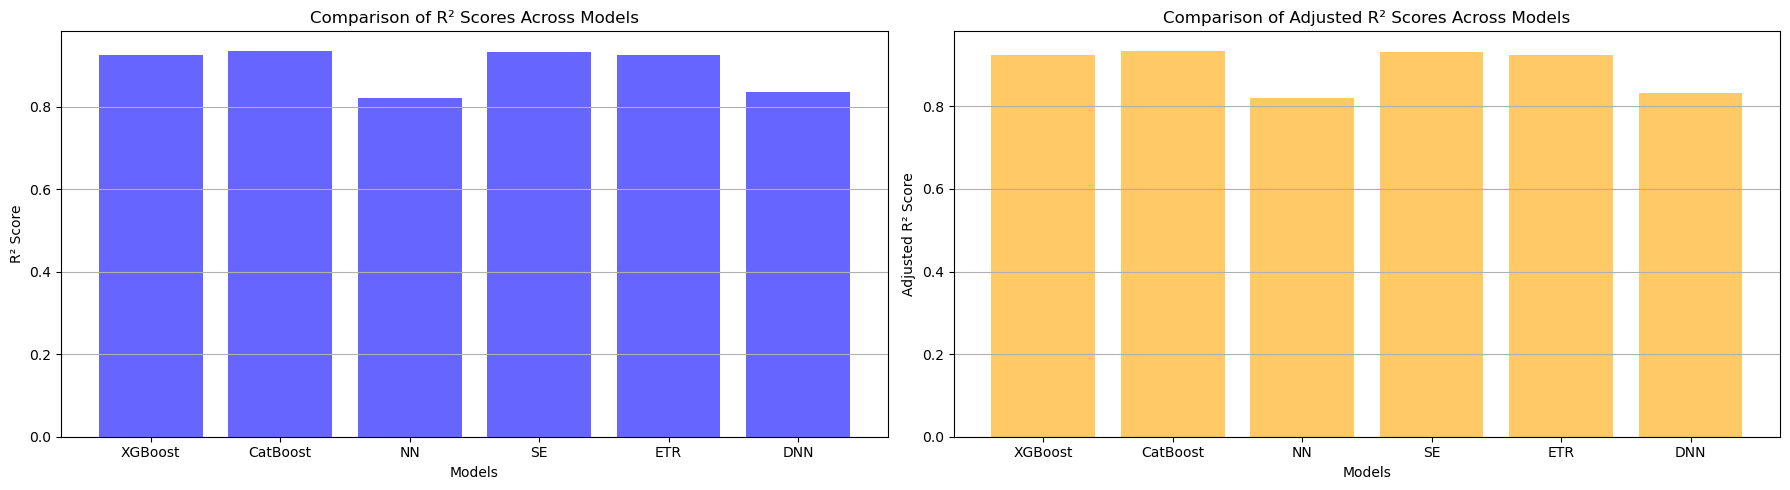

In [53]:
# Define x labels for models
x_labels = ["XGBoost", "CatBoost", "NN" ,"SE", "ETR", "DNN"]

# Define y values for R² and Adjusted R² (handle None values)
r2_values = [best_xgb_r2, best_cat_r2,best_nn_r2, stack_r2, et_r2, best_dnn_r2]
adjusted_r2_values = [val if val is not None else 0 for val in [best_xgb_adj_r2, best_cat_adj_r2, best_nn_adj_r2, stack_adj_r2, et_adj_r2, best_dnn_adj_r2]]

# Create a figure with 2 columns (side-by-side subplots)
plt.style.use('default')

fig, axs = plt.subplots(1, 2, figsize=(18, 5))

# Plot R² Scores
axs[0].bar(x_labels, r2_values, color='blue', alpha=0.6)
axs[0].set_title("Comparison of R² Scores Across Models")
axs[0].set_xlabel("Models")
axs[0].set_ylabel("R² Score")
axs[0].grid(axis='y')

# Plot Adjusted R² Scores
axs[1].bar(x_labels, adjusted_r2_values, color='orange', alpha=0.6)
axs[1].set_title("Comparison of Adjusted R² Scores Across Models")
axs[1].set_xlabel("Models")
axs[1].set_ylabel("Adjusted R² Score")
axs[1].grid(axis='y')

plt.tight_layout()
plt.show()

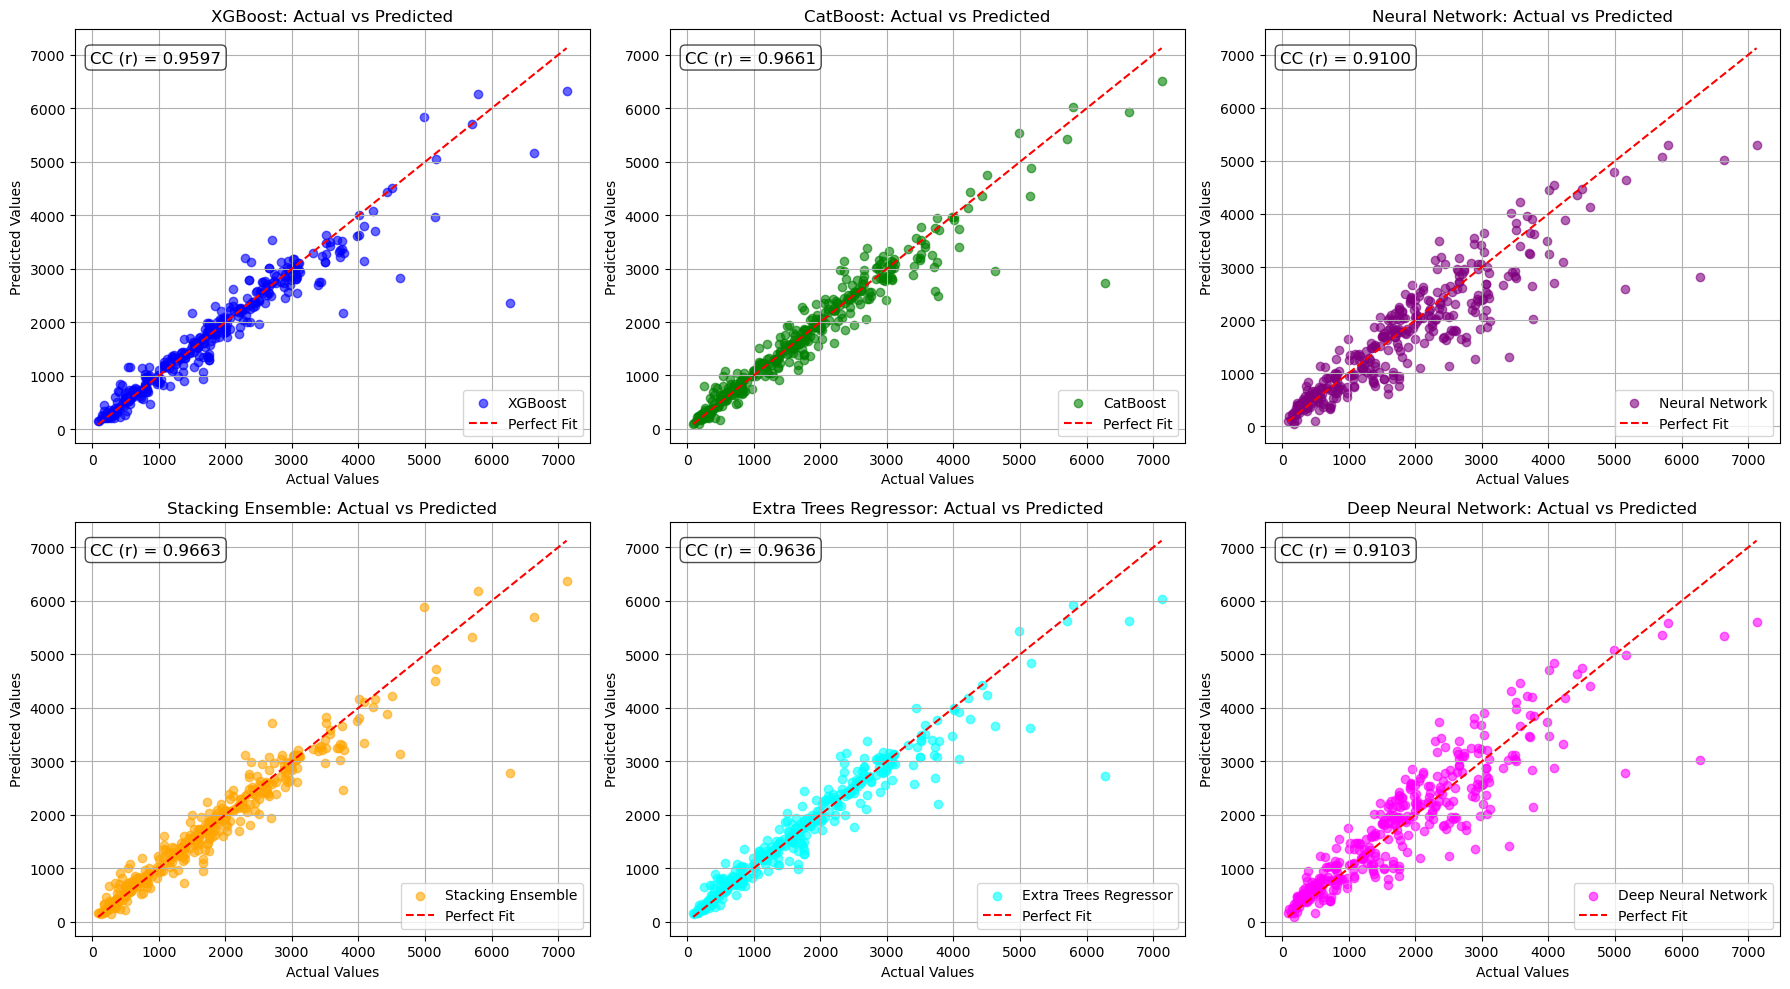

In [54]:
from scipy.stats import pearsonr

# Create figure and axes globally for 6 subplots (3 columns × 2 rows)
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()
plot_index = 0  # Global counter to keep track of subplot index

def plot_actual_vs_predicted(y_test, y_pred, model_name, color):
    global plot_index  # Use the shared subplot index
    y_test = np.array(y_test).flatten()
    y_pred = np.array(y_pred).flatten()

    # Compute correlation coefficient (Pearson's r)
    cc, _ = pearsonr(y_test, y_pred)

    # Plot on the current subplot
    ax = axes[plot_index]
    ax.scatter(y_test, y_pred, color=color, alpha=0.6, label=f"{model_name}")
    ax.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label="Perfect Fit")

    ax.text(0.03, 0.95, f"CC (r) = {cc:.4f}", transform=ax.transAxes,
             fontsize=12, verticalalignment='top', bbox=dict(boxstyle="round", facecolor="white", alpha=0.7))

    # Labels and title
    ax.set_xlabel("Actual Values")
    ax.set_ylabel("Predicted Values")
    ax.set_title(f"{model_name}: Actual vs Predicted")
    ax.legend(loc='lower right')
    ax.grid(True)

    plot_index += 1  

plot_actual_vs_predicted(y_test, y_pred_xgb, "XGBoost", "blue")
plot_actual_vs_predicted(y_test, y_pred_cat, "CatBoost", "green")
plot_actual_vs_predicted(y_test, y_pred_nn, "Neural Network", "purple")
plot_actual_vs_predicted(y_test, stack_preds, "Stacking Ensemble", "orange")
plot_actual_vs_predicted(y_test, et_preds, "Extra Trees Regressor", "cyan")
plot_actual_vs_predicted(y_test, dnn_preds, "Deep Neural Network", "magenta")

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.model_selection import cross_validate, KFold

# Use best hyperparameters from earlier tuning
models = {
    "XGBoost": XGBRegressor(**best_xgb_params, random_state=42),
    "CatBoost": CatBoostRegressor(**best_cat_params, random_state=42, logging_level='Silent'),
    "Neural Network": best_nn_model,
    "Stacking Ensemble": stack,
    "Extra Trees Regressor": et_model,
    "Deep Neural Network": best_dnn_model
}

# Cross-validation setup
cv = KFold(n_splits=5, shuffle=True, random_state=42)

results = []

for name, model in models.items():
    cv_scores = cross_validate(
        model, X, y.values.ravel(),
        scoring=['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2'],
        cv=cv, return_train_score=False
    )
    
    rmse = np.sqrt(-cv_scores['test_neg_mean_squared_error'])
    mae = -cv_scores['test_neg_mean_absolute_error']
    r2 = cv_scores['test_r2']
    
    results.append({
        "Model": name,
        "RMSE Mean": rmse.mean(),
        "RMSE Std": rmse.std(),
        "MAE Mean": mae.mean(),
        "MAE Std": mae.std(),
        "R² Mean": r2.mean(),
        "R² Std": r2.std()
    })

# Create results table
cv_df = pd.DataFrame(results).sort_values(by="RMSE Mean")
pd.set_option('display.expand_frame_repr', False)
print("\n📊 5-Fold Cross-Validation Summary:")
print(cv_df)

In [ ]:
# Short x labels to match your preferred style
x_labels = ["XGBoost", "CatBoost", "NN", "SE", "ETR", "DNN"]

# Pull values from cv_df in the correct order
rmse_values = cv_df["RMSE Mean"].values
rmse_std = cv_df["RMSE Std"].values
r2_values = cv_df["R² Mean"].values
r2_std = cv_df["R² Std"].values

# Set up side-by-side bar plots
plt.style.use('default')
fig, axs = plt.subplots(1, 2, figsize=(18, 5))

# Plot RMSE
axs[0].bar(x_labels, rmse_values, yerr=rmse_std, capsize=5, color='green', alpha=0.8)
axs[0].set_title("Comparison of RMSE Across Models")
axs[0].set_xlabel("Models")
axs[0].set_ylabel("RMSE")
axs[0].grid(axis='y')

# Plot R²
axs[1].bar(x_labels, r2_values, yerr=r2_std, capsize=5, color='purple', alpha=0.8)
axs[1].set_title("Comparison of R² Scores Across Models")
axs[1].set_xlabel("Models")
axs[1].set_ylabel("R² Score")
axs[1].grid(axis='y')

plt.tight_layout()
plt.show()